In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
from scipy.signal import savgol_filter

In [86]:
def read_file_list(file_list):
    o = []
    for f in file_list:
        objects = []
        with (open(f, "rb")) as openfile:
            while True:
                try:
                    objects.append(pickle.load(openfile))
                except EOFError:
                    break
        o.append(objects)
    return o

In [355]:
def plot_eval(folder_list, label_list):
    assert(len(folder_list) == len(label_list))
    
    a_list = []
    
    for f in folder_list:
        dirs_containing_res = os.listdir(f)
        eval_file_list = []
        
        try:
            for d in dirs_containing_res:
                eval_file_list.append(f + d + "/eval.pkl")
            e = read_file_list(eval_file_list)
            e = np.array(e)
            e = e.reshape(e.shape[0], e.shape[-1])
            
        except:
            eval_file_list = []
            
            for d in dirs_containing_res:
                eval_file_list.append(f + d + "/eval")

            e = read_file_list(eval_file_list)
            e = np.array(e)
            e = e.reshape(e.shape[0], e.shape[-1])
        
        
        a_list.append(e)
    
    for i, label in enumerate(label_list):
        x = np.arange(len(np.mean(a_list[i], 0)))
        
        m = np.mean(a_list[i], 0)
        std = np.std(a_list[i], 0)
        
        plt.plot(x, m, label=label)
        plt.fill_between(x, m - std, m + std, alpha=0.2)
    plt.legend()
    plt.show()
    
    return a_list


In [361]:
def plot_test_seq(folder_list, seq_idx, has_mode_list, label_list, seqname):
    mode_label_list = ['StdGP', 'NoStdGP', 'TruePrior']
    a_list = []
    
    for f in folder_list:
        dirs_containing_res = os.listdir(f)
        test_file_list = []
        
        try:
            for d in dirs_containing_res:
                test_file_list.append(f + d + "/test")
            e = read_file_list(test_file_list)
            e = np.array(e)
            e = e.squeeze(1)
        except:
            test_file_list = []
            
            for d in dirs_containing_res:
                test_file_list.append(f + d + "/test.pkl")

            e = read_file_list(test_file_list)
            e = np.array(e)
            e = e.squeeze(1)
            
        a_list.append(e)
    
    for i, a in enumerate(a_list):
        if has_mode_list[i]:
            for mode in range(3):
                v = a[:, :, mode, seq_idx]
                v = v.tolist()
                v = np.array(v)
                
                m = np.mean(v, (0,2))
                std = np.std(v, (0,2))
                x = np.arange(len(m))
                plt.plot(x, m, label=label_list[i] + " " + mode_label_list[mode])
                plt.fill_between(x, m - std, m + std, alpha=0.2)
        else:
            v = a[:, :, seq]
            v = v.tolist()
            v = np.array(v)
            
            m = np.mean(v, (0, 2))
            std = np.std(v, (0, 2))
            
            x = np.arange(len(m))
            plt.plot(x, m, label=label_list[i])
            plt.fill_between(x, m - std, m + std, alpha=0.2)
            
    plt.title("Sequence {}".format(seqname))
    plt.legend(title='title', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

# RESULTS

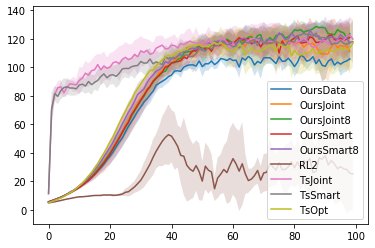

In [534]:
files = ["../result/newnewgaussv0/oursdata/",
         "../result/newnewgaussv0/oursjointnew/",
         "../result/newnewgaussv0/oursjointnewhs/",
         "../result/newnewgaussv0/ourssmartcp/",
         "../result/newnewgaussv0/ourssmartcphs/",
         "../result/newnewgaussv0/rl2/",
         "../result/newnewgaussv0/tsjoint/",
         "../result/newnewgaussv0/tssmart/",
        "../result/newnewgaussv0/tsoptupd/"]

labels = ['OursData',
               'OursJoint',
               'OursJoint8',
               'OursSmart',
               'OursSmart8',
               'RL2',
               'TsJoint',
               'TsSmart',
         'TsOpt']

r = plot_eval(files, labels)

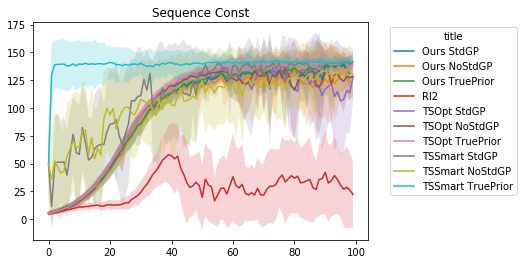

In [535]:
plot_test_seq(["../result/newnewgaussv0/ourssmartcphs/",
               "../result/newnewgaussv0/rl2/",
              "../result/newnewgaussv0/tsoptupd/",
              "../result/newnewgaussv0/tssmart/"], 
              seq_idx=0, 
              has_mode_list=[True, False,True, True], 
              label_list=['Ours',
                          'Rl2',
                          'TSOpt',
                          'TSSmart'],
              seqname='Const')

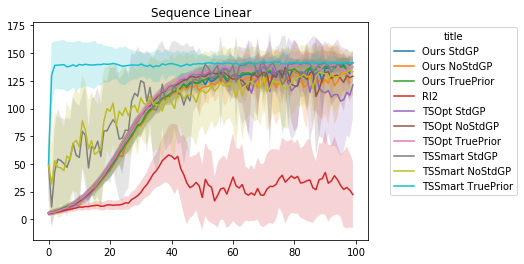

In [536]:
plot_test_seq(["../result/newnewgaussv0/ourssmartcphs/",
               "../result/newnewgaussv0/rl2/",
              "../result/newnewgaussv0/tsoptupd/",
              "../result/newnewgaussv0/tssmart/"], 
              seq_idx=1, 
              has_mode_list=[True, False,True, True], 
              label_list=['Ours',
                          'Rl2',
                          'TSOpt',
                          'TSSmart'],
              seqname='Linear')

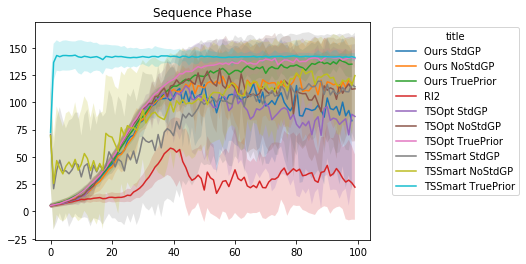

In [537]:
plot_test_seq(["../result/newnewgaussv0/ourssmartcphs/",
               "../result/newnewgaussv0/rl2/",
              "../result/newnewgaussv0/tsoptupd/",
              "../result/newnewgaussv0/tssmart/"], 
              seq_idx=2, 
              has_mode_list=[True, False,True, True], 
              label_list=['Ours',
                          'Rl2',
                          'TSOpt',
                          'TSSmart'],
              seqname='Phase')

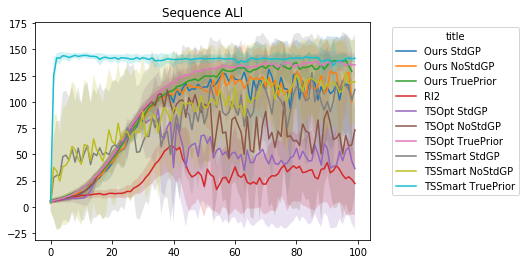

In [538]:
plot_test_seq(["../result/newnewgaussv0/ourssmartcphs/",
               "../result/newnewgaussv0/rl2/",
              "../result/newnewgaussv0/tsoptupd/",
              "../result/newnewgaussv0/tssmart/"], 
              seq_idx=3, 
              has_mode_list=[True, False,True, True], 
              label_list=['Ours',
                          'Rl2',
                          'TSOpt',
                          'TSSmart'],
              seqname='ALl')

# Sequence tracking and non-stationary ablation

In [504]:
import torch
import numpy as np
import pickle

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Product, ConstantKernel as C

import gym_sin
from gym import spaces

from utilities.arguments import get_args
from learner.posterior_multi_task import PosteriorMTAgent
from inference.inference_network import InferenceNetwork
from task.GuassianTaskGenerator import GaussianTaskGenerator


def get_const_task_sequence(alpha, n_restarts, num_test_processes, std):
    kernel = C(1.0, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5))

    gp_list = []
    for i in range(num_test_processes):
        gp_list.append([GaussianProcessRegressor(kernel=kernel,
                                                 alpha=alpha ** 2,
                                                 normalize_y=True,
                                                 n_restarts_optimizer=n_restarts)
                        for _ in range(num_test_processes)])
    init_prior_test = [torch.tensor([[-10], [5]], dtype=torch.float32) for _ in range(num_test_processes)]

    mean = -5

    prior_seq = []
    for idx in range(15):
        prior_seq.append(torch.tensor([[mean], [std]], dtype=torch.float32))

    return gp_list, prior_seq, init_prior_test


def get_linear_task_sequence(alpha, n_restarts, num_test_processes, std):
    kernel = C(1.0, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5))

    gp_list = []
    for i in range(num_test_processes):
        gp_list.append([GaussianProcessRegressor(kernel=kernel,
                                                 alpha=alpha ** 2,
                                                 normalize_y=True,
                                                 n_restarts_optimizer=n_restarts)
                        for _ in range(num_test_processes)])
    init_prior_test = [torch.tensor([[30], [5]], dtype=torch.float32) for _ in range(num_test_processes)]

    prior_seq = []
    for idx in range(20):
        mean = 30 - idx

        prior_seq.append(torch.tensor([[mean], [std]], dtype=torch.float32))

    return gp_list, prior_seq, init_prior_test


def get_phase_task_sequence(alpha, n_restarts, num_test_processes, std):
    kernel = C(1.0, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5))

    gp_list = []
    for i in range(num_test_processes):
        gp_list.append([GaussianProcessRegressor(kernel=kernel,
                                                 alpha=alpha ** 2,
                                                 normalize_y=True,
                                                 n_restarts_optimizer=n_restarts)
                        for _ in range(num_test_processes)])
    init_prior_test = [torch.tensor([[-5], [5]], dtype=torch.float32) for _ in range(num_test_processes)]

    prior_seq = []
    for idx in range(40):
        if idx < 15:
            mean = 0
        elif idx < 30:
            mean = 10
        else:
            mean = 0

        prior_seq.append(torch.tensor([[mean], [std]], dtype=torch.float32))

    return gp_list, prior_seq, init_prior_test


def get_abrupt_and_smooth(alpha, n_restarts, num_test_processes, std):
    kernel = C(1.0, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5))

    gp_list = []
    for i in range(num_test_processes):
        gp_list.append([GaussianProcessRegressor(kernel=kernel,
                                                 alpha=alpha ** 2,
                                                 normalize_y=True,
                                                 n_restarts_optimizer=n_restarts)
                        for _ in range(num_test_processes)])
    init_prior_test = [torch.tensor([[-30], [5]], dtype=torch.float32) for _ in range(num_test_processes)]
    prior_seq = []

    for idx in range(60):
        if idx < 15:
            mean = -30
        elif idx < 50:
            mean = -20 + (idx - 15)
        else:
            mean = -20 + 50 - 15

        prior_seq.append(torch.tensor([[mean], [std]], dtype=torch.float32))

    return gp_list, prior_seq, init_prior_test


In [426]:
env_name = "gauss-v0"

action_space = spaces.Box(low=np.array([-1]), high=np.array([1]))
latent_dim = 1

x_min = -100
x_max = 100

min_mean = -60
max_mean = 60

prior_mu_min = -10
prior_mu_max = 10
prior_std_min = 1
prior_std_max = 10

std = 5
amplitude=1

device = "cpu"

task_generator = GaussianTaskGenerator(x_min, x_max, min_mean, max_mean,
                 prior_mu_min, prior_mu_max, prior_std_min, prior_std_max, std, amplitude)
fam = task_generator.create_task_family(n_tasks=5000, n_batches=1, test_perc=0, batch_size=1)

In [519]:
def view_tracking(folder, gp_list, prior_seq, init_prior, sw_size, env_name, seed, log_dir, use_env_obs, num_eval_proc,
                  task_generator):
    dirs_containing_res = os.listdir(folder)
    ac_list = []
    vi_list = []
    for d in dirs_containing_res:
        model_list.append(torch.load(folder + d + "/agent_ac"))
        vi_list.append(torch.load(folder + d + "/agent_vi"))
        
    eval_true_sigma_list = []
    posterior_history_true_sigma_list = []
    prediction_mean_true_sigma_list = []

    eval_false_sigma_list = []
    posterior_history_false_sigma_list = []
    prediction_mean_false_sigma_list = []

    eval_prior = []

    for model, vi in zip(model_list, vi_list):
        agent = PosteriorMTAgent(action_space=spaces.Box(low=np.array([-1]), high=np.array([1])), 
                                 device="cpu", 
                                 gamma=1,
                                     num_steps=150, num_processes=32,
                                     clip_param=None, ppo_epoch=None,
                                     num_mini_batch=None,
                                     value_loss_coef=None,
                                     entropy_coef=None,
                                     lr=0.1,
                                     eps=0.1, max_grad_norm=0.5,
                                     use_linear_lr_decay=False,
                                     use_gae=False,
                                     gae_lambda=None,
                                     use_proper_time_limits=None,
                                     obs_shape=(2,),
                                     latent_dim=1,
                                     recurrent_policy=False,
                                     hidden_size=4,
                                     use_elu=True,
                                     variational_model=None,
                                     vae_optim=None,
                                     rescale_obs=True,
                                     max_old=[100, 10],
                                     min_old=[-100, 0],
                                     vae_min_seq=None,
                                     vae_max_seq=None,
                                     max_action=100,
                                     min_action=-100,
                                     use_time=False,
                                     rescale_time=None,
                                     max_time=None,
                                     max_sigma=10)
        agent.actor_critic = model
        agent.vae = vi

        envs_args = [task_generator.sample_task_from_prior(prior_seq[i]) for i in range(len(prior_seq))]
        eval_episode, posterior_history, prediction_mean = agent.test_task_sequence(gp_list, 10, 'gauss-v0', 0, ".",
                                                  envs_args, init_prior,
                                                  False, 1, use_true_sigma=True,
                                                  use_real_prior=False)
        eval_true_sigma_list.append(eval_episode)
        posterior_history_true_sigma_list.append(posterior_history)
        prediction_mean_true_sigma_list.append(prediction_mean)

        eval_episode, posterior_history, prediction_mean = agent.test_task_sequence(gp_list, 10, 'gauss-v0', 0, ".",
                                                  envs_args, init_prior,
                                                  False, 1, use_true_sigma=False,
                                                  use_real_prior=False)

        eval_false_sigma_list.append(eval_episode)
        posterior_history_false_sigma_list.append(posterior_history)
        prediction_mean_false_sigma_list.append(prediction_mean)

        eval_episode, _, _ = agent.test_task_sequence(gp_list, 10, 'gauss-v0', 0, ".",
                                                  envs_args, init_prior,
                                                  False, 1, use_true_sigma=None,
                                                  use_real_prior=True,
                                                     true_prior_sequence=prior_seq)

        eval_prior.append(eval_episode)
    
    seq_len = len(prior_seq)
    x = np.arange(seq_len)

    #eval_true_sigma_list = np.array(eval_true_sigma_list)
    m = np.mean(eval_true_sigma_list, 0)
    std = np.std(eval_true_sigma_list, 0)
    plt.plot(x, m, label="True sigma")
    plt.fill_between(x, m - std, m + std, alpha=0.2)

    #eval_false_sigma_list = np.array(eval_false_sigma_list)
    m = np.mean(eval_false_sigma_list, 0)
    std = np.std(eval_false_sigma_list, 0)
    plt.plot(x, m, label="False sigma")
    plt.fill_between(x, m - std, m + std, alpha=0.2)

    #eval_prior = np.array(eval_prior)
    m = np.mean(eval_prior, 0)
    std = np.std(eval_prior, 0)
    plt.plot(x, m, label="True prior")
    plt.fill_between(x, m - std, m + std, alpha=0.2)

    plt.legend(title='Algorithm', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.plot()
    plt.show()
    
    history_true_sigma = []
    for proc in range(10):
        curr_h = []
        for t_idx in range(seq_len):
            curr_h.append(posterior_history_true_sigma_list[proc][t_idx][0,0].item())
        history_true_sigma.append(curr_h)

    prediction_mean_true_sigma_list = np.array(prediction_mean_true_sigma_list)
    
    history_false_sigma = []
    for proc in range(10):
        curr_h = []
        for t_idx in range(seq_len):
            curr_h.append(posterior_history_false_sigma_list[proc][t_idx][0,0].item())
        history_false_sigma.append(curr_h)

    prediction_mean_false_sigma_list = np.array(prediction_mean_false_sigma_list)
    
    m = np.mean(prediction_mean_true_sigma_list, 0)
    std = np.mean(prediction_mean_true_sigma_list, 0)
    plt.plot(x, m, label="GP Pred True sigma")
    plt.fill_between(x, m - std, m + std, alpha=0.2)

    m = np.mean(history_true_sigma, 0)
    std = np.mean(history_true_sigma, 0)
    plt.plot(x, m, label="Posterior True")
    plt.fill_between(x, m - std, m + std, alpha=0.2)

    m = np.mean(prediction_mean_false_sigma_list, 0)
    std = np.mean(prediction_mean_false_sigma_list, 0)
    plt.plot(x, m, label="GP Pred False sigma")
    plt.fill_between(x, m - std, m + std, alpha=0.2)

    m = np.mean(history_false_sigma, 0)
    std = np.mean(history_false_sigma, 0)
    plt.plot(x, m, label="Posterior False")
    plt.fill_between(x, m - std, m + std, alpha=0.2)

    t = [prior_seq[i][0].item() for i in range(seq_len)]
    plt.plot(x, t, label="True task")

    plt.legend(title='Algorithm', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.plot()

Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...


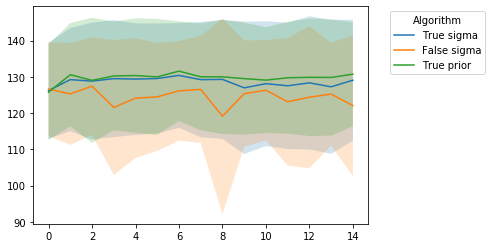

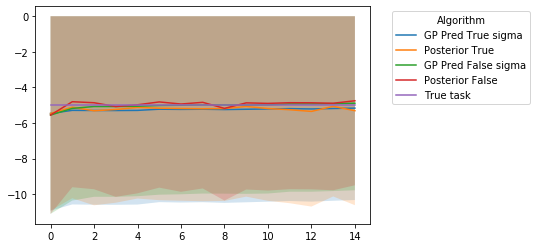

In [522]:
gp_list, prior_seq, init_prior = get_const_task_sequence(0.25, 1, 1, 0.1)
folder = "../result/newnewgaussv0/ourssmartcphs/"
view_tracking(folder, gp_list, prior_seq, init_prior, 10, 
              "gauss-v0", 0, ".", False, 1,
              task_generator)

Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...


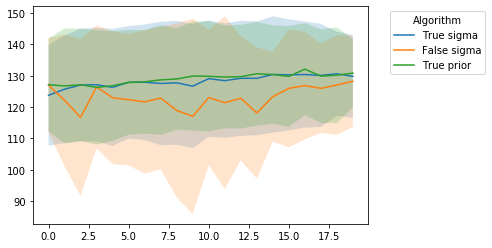

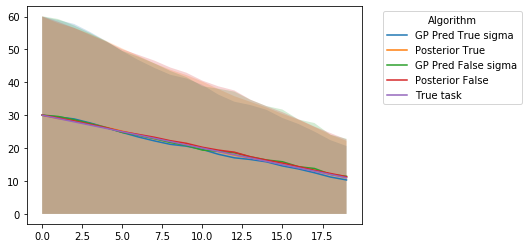

In [523]:
gp_list, prior_seq, init_prior = get_linear_task_sequence(0.25, 1, 1, 0.1)
folder = "../result/newnewgaussv0/ourssmartcphs/"
view_tracking(folder, gp_list, prior_seq, init_prior, 10, 
              "gauss-v0", 0, ".", False, 1,
              task_generator)

Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...


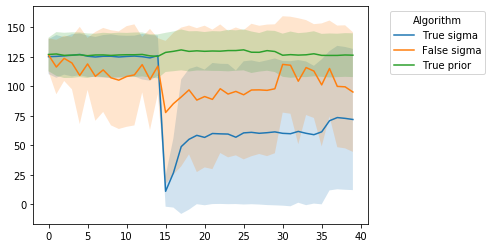

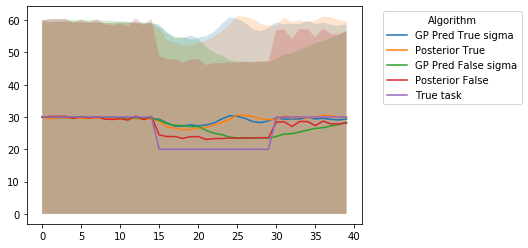

In [520]:
gp_list, prior_seq, init_prior = get_phase_task_sequence(0.25, 1, 1, 0.1)
folder = "../result/newnewgaussv0/ourssmartcphs/"
view_tracking(folder, gp_list, prior_seq, init_prior, 10, 
              "gauss-v0", 0, ".", False, 1,
              task_generator)

Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...


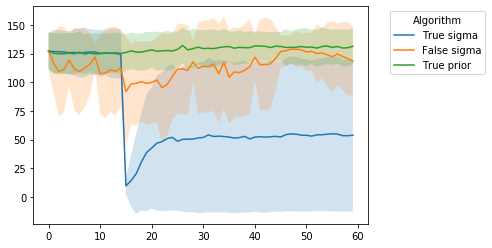

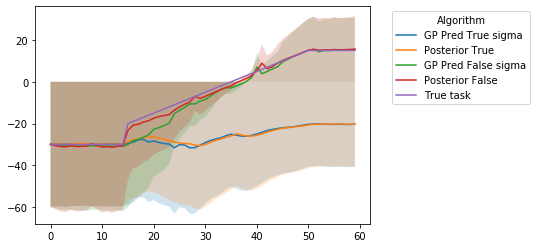

In [521]:
gp_list, prior_seq, init_prior = get_abrupt_and_smooth(0.25, 1, 1, 0.1)
folder = "../result/newnewgaussv0/ourssmartcphs/"
view_tracking(folder, gp_list, prior_seq, init_prior, 10, 
              "gauss-v0", 0, ".", False, 1,
              task_generator)

In [553]:
task_generator.prior_dist[0][1]

tensor([4.1285])

In [561]:
torch.log(torch.tensor([2.71828182846]))

tensor([1.])

10.0